In [6]:
#pip install fitter

In [1]:
import os
import pyodbc
import STG_CBK as bi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn import preprocessing

In [6]:
sql_sr = """ SELECT PORTAFOLIO_NUEVO, LOG(LGD +1000)LGD
             FROM STG_CBK.DBO.LGD_RESULTADO 
             WHERE 
             FECHA IN( SELECT MIN(FECHA) 
                             FROM STG_CBK.DBO.LGD_RESULTADO
                             GROUP BY NUM_CREDITO)"""

In [7]:
dataset =  pd.read_sql(sql_sr, bi.conn)
dataset.head()

,PORTAFOLIO_NUEVO,LGD
0,FACTORING,6.907755
1,FACTORING,6.908193
2,FACTORING,6.907755
3,FACTORING,6.907755
4,FACTORING,6.907755


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18548 entries, 0 to 18547
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PORTAFOLIO_NUEVO  18546 non-null  object 
 1   LGD               18548 non-null  float64
dtypes: float64(1), object(1)
memory usage: 289.9+ KB


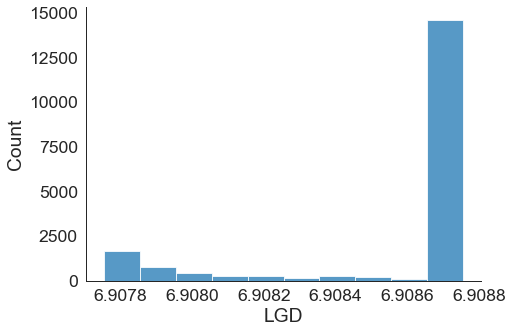

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dataset, x="LGD", kind="hist", bins=10, aspect=1.5)

In [10]:
lgd1 = dataset["LGD"].values

,sumsquare_error,aic,bic,kl_div
beta,4.957880e+09,-968.645047,2.318175e+05,1.334229
norm,5.557175e+09,-1242.136513,2.339144e+05,2.660596
burr,5.660307e+09,-829.572000,2.342751e+05,2.438590
gama,inf,inf,inf,inf
log_normal,inf,inf,inf,inf


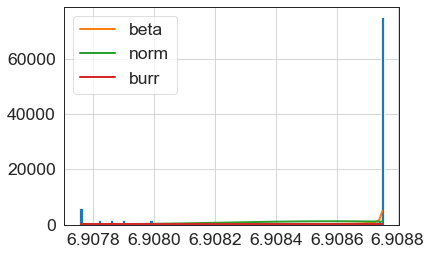

In [11]:
f = Fitter(lgd1,
          distributions=['gama',
                        'log_normal',
                        'beta',
                        'burr',
                        'norm'])
f.fit()
f.summary()

In [15]:
f.get_best(method='sumsquare_error')

{'beta': {'a': 336.73090688465584,
  'b': 0.14941605556165224,
  'loc': -6.79698153515743,
  'scale': 7.796981535157431}}

In [12]:
f.fitted_param["beta"]

(0.16137264901469778,
 0.035998475742331025,
 6.907555447678699,
 0.0011993316365215478)

In [13]:
beta = f.fitted_param["beta"]
beta

(0.16137264901469778,
 0.035998475742331025,
 6.907555447678699,
 0.0011993316365215478)

In [14]:
a, b, loc, scale = beta[0], beta[1],beta[2],beta[3] 

In [15]:
from scipy import stats
data = stats.beta.rvs(a, b, loc=loc, scale=scale, size=100000)

def promedio(size):
    data =stats.beta.rvs(a, b, loc=loc, scale=scale, size=size)
    m =np.mean(data)
    media = media[m]
    return m

In [16]:
m = []
def promedio(size):
    data =stats.beta.rvs(a, b, loc=loc, scale=scale, size=size)
    m.append(np.mean(data))
    return m

In [17]:
for size in range(1,10000):
    promedio(size)

In [18]:
media_total=np.mean(m)

In [19]:
std_total =np.std(m)

In [20]:
n_total = dataset.shape[0]

In [21]:
intervalo_total = st.t.interval(alpha=0.95, df=len(m)-1, loc = np.mean(m), scale=st.sem(m))

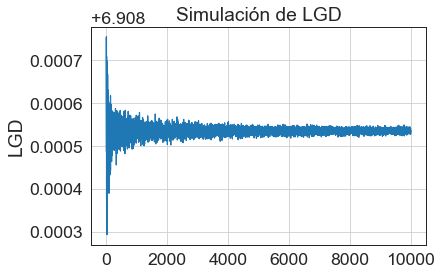

In [23]:
plt.plot(m)
plt.ylabel('LGD')
plt.title('Simulación de LGD')
#plt.text(1000, 0.4, r'Beta(0.046, 0.013, -0.103, 1.103)')
plt.grid(True)

# Calculo de LGD por Portafolio

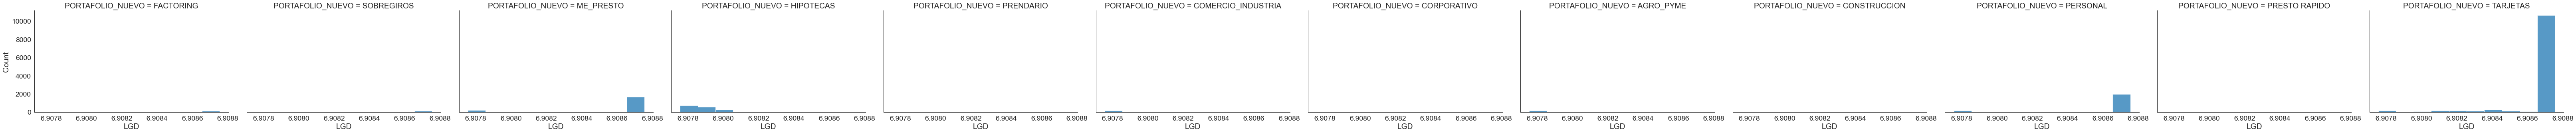

In [24]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dataset, x="LGD", kind="hist", bins=10, aspect=1.5, col='PORTAFOLIO_NUEVO')

In [25]:
portafolio = dataset['PORTAFOLIO_NUEVO'].unique() 
portafolio

array(['FACTORING', 'SOBREGIROS', 'ME_PRESTO', 'HIPOTECAS', 'PRENDARIO',
       'COMERCIO_INDUSTRIA', 'CORPORATIVO', 'AGRO_PYME', 'CONSTRUCCION',
       'PERSONAL', 'PRESTO RAPIDO', 'TARJETAS', None], dtype=object)

In [29]:
condiciones = [
    (dataset['PORTAFOLIO_NUEVO'] == 'FACTORING'), # 1
    (dataset['PORTAFOLIO_NUEVO'] == 'SOBREGIROS'), # 2
    (dataset['PORTAFOLIO_NUEVO'] == 'ME_PRESTO'),  # 3
    (dataset['PORTAFOLIO_NUEVO'] == 'HIPOTECAS'),  # 4
    (dataset['PORTAFOLIO_NUEVO'] == 'COMERCIO_INDUSTRIA'), # 5
    (dataset['PORTAFOLIO_NUEVO'] == 'CORPORATIVO'),        # 6
    (dataset['PORTAFOLIO_NUEVO'] == 'AGRO_PYME'),          # 7
    (dataset['PORTAFOLIO_NUEVO'] == 'CONSTRUCCION'),       # 8
    (dataset['PORTAFOLIO_NUEVO'] == 'PERSONAL'),           # 9
    (dataset['PORTAFOLIO_NUEVO'] == 'PRESTO RAPIDO'),      # 10
    (dataset['PORTAFOLIO_NUEVO'] == 'TARJETAS')]           # 11
eleccion = ['1', '2', '3', '4' ,'5','6','7','8','9','10','11']
dataset['cod_portafolio'] = np.select(condiciones, eleccion)

In [141]:
#dataset
#dataset['cod_portafolio']==0
dataset['cod_portafolio'].unique()

array(['11', '3', '1', '5', '4', '7', '8', '6', '0', '9'], dtype=object)

In [30]:
dataset.groupby(['PORTAFOLIO_NUEVO']).size()

PORTAFOLIO_NUEVO
AGRO_PYME                1
COMERCIO_INDUSTRIA       1
CONSTRUCCION             1
CORPORATIVO              3
FACTORING                8
HIPOTECAS               12
ME_PRESTO              658
PERSONAL               540
TARJETAS              2804
dtype: int64

In [138]:
for i in dataset['cod_portafolio'].unique():
    locals()['data' + i] = dataset.loc[(dataset.cod_portafolio == i), 'LGD']

In [142]:
# Solo usar la primera vez
parametros = {'distribucion' : ['distr'],
              #'t':0,
              'n': 0,
              'a': 0,
              'b': 0,
              #'c': 0,
              'locale': 0,
              'scale': 0}
df = pd.DataFrame( data = parametros)
df

,distribucion,n,a,b,locale,scale
0,distr,0,0,0,0,0


In [167]:
data_modelar = [data11]
                #data0, data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11]
for i in data_modelar:
    min_max_scaler = preprocessing.MinMaxScaler()
    data_minmax = min_max_scaler.fit_transform(i.values.reshape(-1,1))
    f = Fitter(data_minmax,
              distributions=['gama','log_normal', 'beta','burr', 'norm', 'weibull'])
    f.fit()
   #f.summary()
    best_model = f.get_best(method='sumsquare_error')
    print(best_model)  

NameError: name 'data12' is not defined

In [166]:
for key in best_model:
  #print (key, ":", z[key])
  list = [key]
  list.append(best_model[key])
  distr =list[0]
  a= list[1]['a']
  b= list[1]['b']
  #c= list[1]['c']
  locale= list[1]['loc']
  scale= list[1]['scale']
 # skew = list[1]['skew']
  n = len(data_modelar[0])

parametros = {'distribucion' : distr, 'n':n ,'a': a, 'b': b,'locale': locale, 'scale':scale}
#parametros
df = df.append(parametros, ignore_index=True)
df

,distribucion,n,a,b,locale,scale
0,distr,0,0.000000,0.000000,0.000000e+00,0.000000
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241
2,norm,8,0.000000,0.000000,8.670375e-01,0.328360
3,beta,658,547.597199,0.210786,-8.778761e+00,9.778761
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
6,beta,3,2.323547,0.265693,-4.258356e-01,1.425836
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
9,beta,540,383.734089,0.327808,-3.503537e+00,4.503537


df1 = df.copy()

df1.index.to_list()

In [168]:
df =df.drop([0])
df

,distribucion,n,a,b,locale,scale
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241
2,norm,8,0.000000,0.000000,8.670375e-01,0.328360
3,beta,658,547.597199,0.210786,-8.778761e+00,9.778761
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
6,beta,3,2.323547,0.265693,-4.258356e-01,1.425836
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
9,beta,540,383.734089,0.327808,-3.503537e+00,4.503537
10,beta,2804,644.650762,0.284014,-1.859975e+00,2.859975


In [169]:
df_beta =df[df['distribucion'] == "beta"]
df_beta

,distribucion,n,a,b,locale,scale
3,beta,658,547.597199,0.210786,-8.778761,9.778761
6,beta,3,2.323547,0.265693,-0.425836,1.425836
9,beta,540,383.734089,0.327808,-3.503537,4.503537
10,beta,2804,644.650762,0.284014,-1.859975,2.859975


In [66]:
#range(df_beta.shape[0])

In [170]:
simulacion = []
for i in range(df_beta.shape[0]):
    for size in range(1,1000):
        a, b, loc, scale = df_beta.iloc[i,2],df_beta.iloc[i,3], df_beta.iloc[i,4], df_beta.iloc[i,5]
        data =st.beta.rvs(a, b, loc=loc, scale=scale, size=size)
        prom = np.mean(data)
        inter = st.t.interval(alpha=0.95, df=len(data)-1, loc = np.mean(data), scale=st.sem(data))
        simulacion.append(
            {'muestra': i, 
             'media':prom ,
             'lim_inf': inter[0], 
             'lim_sup': inter[1]}
        )
        simulacion1 = pd.DataFrame(simulacion)

In [277]:
#simulacion1.head(50)

In [171]:
intervalo_media =[]
for i in range(df_beta.shape[0]):
    k = simulacion1.loc[simulacion1.loc[:,'muestra']==i]['media']
    intervalo_m =st.t.interval(alpha=0.95, df=len(k)-1, 
                               loc = np.mean(k), 
                               scale=st.sem(k))
    intervalo_media.append (
        {
             'modelo': i, 
             'lim_inf': intervalo_m[0], 
             'lim_sup': intervalo_m[1]
        }
    )
    intervalo_media1 =pd.DataFrame(intervalo_media)

In [172]:
df_resu1 = pd.concat([simulacion1.groupby('muestra')['media'].mean(),
            simulacion1.groupby('muestra')['media'].std()],
          axis = 1)

In [173]:
df_resu1.columns = ['media', 'std']
df_resu1

,media,std
muestra,,
0,0.996239,0.000807
1,0.853283,0.021911
2,0.996140,0.000635
3,0.998751,0.000161


In [174]:
df_resu2 =pd.concat([intervalo_media1,df_resu1], axis = 1)
df_resu2

,modelo,lim_inf,lim_sup,media,std
0,0,0.996189,0.996289,0.996239,0.000807
1,1,0.851922,0.854643,0.853283,0.021911
2,2,0.996101,0.996179,0.996140,0.000635
3,3,0.998741,0.998761,0.998751,0.000161


In [175]:
df_resu2.index = df_beta.index.to_list()

In [176]:
df_resu3 = pd.concat([df_beta, df_resu2], axis= 1)
df_resu3

,distribucion,n,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
3,beta,658,547.597199,0.210786,-8.778761,9.778761,0,0.996189,0.996289,0.996239,0.000807
6,beta,3,2.323547,0.265693,-0.425836,1.425836,1,0.851922,0.854643,0.853283,0.021911
9,beta,540,383.734089,0.327808,-3.503537,4.503537,2,0.996101,0.996179,0.996140,0.000635
10,beta,2804,644.650762,0.284014,-1.859975,2.859975,3,0.998741,0.998761,0.998751,0.000161


In [177]:
df_burr =df[df['distribucion'] == "burr"]
df_burr

,distribucion,n,a,b,locale,scale
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241


In [178]:
simulacion_b = []
for i in range(df_burr.shape[0]):
    for size in range(1,1000):
        c, d,loc, scale = df_burr.iloc[i,2], df_burr.iloc[i,3],df_burr.iloc[i,4], df_burr.iloc[i,5]
        data =st.burr.rvs(c, d, loc=loc, scale=scale, size=size)
        prom = np.mean(data)
        inter = st.t.interval(alpha=0.95, df=len(data)-1, loc = np.mean(data), scale=st.sem(data))
        simulacion_b.append(
            {'muestra': i, 
             'media':prom ,
             'lim_inf': inter[0], 
             'lim_sup': inter[1]}
        )
        simulacion_b1 = pd.DataFrame(simulacion_b)

In [181]:
intervalo_media_b =[]
for i in range(df_burr.shape[0]):
    k = simulacion_b1.loc[simulacion_b1.loc[:,'muestra']==i]['media']
    intervalo_bm =st.t.interval(alpha=0.95, df=len(k)-1, 
                               loc = np.mean(k), 
                               scale=st.sem(k))
    intervalo_media_b.append (
        {
             'modelo': i, 
             'lim_inf': intervalo_bm[0], 
             'lim_sup': intervalo_bm[1]
        }
    )
    intervalo_media_b1 =pd.DataFrame(intervalo_media_b)

In [182]:
intervalo_media_b1

,modelo,lim_inf,lim_sup
0,0,-6.540195e+50,3.960181e+51
1,1,1.406082e-01,1.443176e-01
2,2,-8.375475e+51,2.613303e+52
3,3,-4.982376e+51,1.943965e+52
4,4,-1.247617e+57,3.841519e+57


In [183]:
df_resu_b1 = pd.concat([simulacion_b1.groupby('muestra')['media'].mean(),
            simulacion_b1.groupby('muestra')['media'].std()],
          axis = 1)

In [184]:
df_resu_b1.columns = ['media', 'std']
df_resu_b1

,media,std
muestra,,
0,1.653081e+51,3.715987e+52
1,1.424629e-01,2.987390e-02
2,8.878776e+51,2.779097e+53
3,7.228636e+51,1.966796e+53
4,1.296951e+57,4.098469e+58


In [185]:
df_resu_b2 =pd.concat([intervalo_media_b1,df_resu_b1], axis = 1)
df_resu_b2

,modelo,lim_inf,lim_sup,media,std
0,0,-6.540195e+50,3.960181e+51,1.653081e+51,3.715987e+52
1,1,1.406082e-01,1.443176e-01,1.424629e-01,2.987390e-02
2,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
3,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
4,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58


In [186]:
df_resu_b2.index = df_burr.index.to_list()

In [187]:
df_resu_b3 = pd.concat([df_burr, df_resu_b2], axis= 1)
df_resu_b3

,distribucion,n,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241,0,-6.540195e+50,3.960181e+51,1.653081e+51,3.715987e+52
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023,1,1.406082e-01,1.443176e-01,1.424629e-01,2.987390e-02
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58


In [188]:
df_resultado = pd.concat([df_resu3, df_resu_b3])
df_resultado

,distribucion,n,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
3,beta,658,547.597199,0.210786,-8.778761e+00,9.778761,0,9.961893e-01,9.962895e-01,9.962394e-01,8.071589e-04
6,beta,3,2.323547,0.265693,-4.258356e-01,1.425836,1,8.519224e-01,8.546431e-01,8.532827e-01,2.191070e-02
9,beta,540,383.734089,0.327808,-3.503537e+00,4.503537,2,9.961006e-01,9.961794e-01,9.961400e-01,6.350203e-04
10,beta,2804,644.650762,0.284014,-1.859975e+00,2.859975,3,9.987408e-01,9.987607e-01,9.987508e-01,1.608446e-04
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241,0,-6.540195e+50,3.960181e+51,1.653081e+51,3.715987e+52
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023,1,1.406082e-01,1.443176e-01,1.424629e-01,2.987390e-02
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58


In [190]:
df_normal =df[df['distribucion'] == "norm"]
df_normal

,distribucion,n,a,b,locale,scale
2,norm,8,0.0,0.0,0.867037,0.32836


In [192]:
simulacion_c = []
for i in range(df_normal.shape[0]):
    for size in range(1,1000):
        loc, scale = df_normal.iloc[i,4], df_normal.iloc[i,5]
        data =st.norm.rvs(loc=loc, scale=scale, size=size)
        prom = np.mean(data)
        inter = st.t.interval(alpha=0.95, df=len(data)-1, loc = np.mean(data), scale=st.sem(data))
        simulacion_c.append(
            {'muestra': i, 
             'media':prom ,
             'lim_inf': inter[0], 
             'lim_sup': inter[1]}
        )
        simulacion_c1 = pd.DataFrame(simulacion_c)

In [195]:
intervalo_media_c =[]
for i in range(df_normal.shape[0]):
    k = simulacion_c1.loc[simulacion_c1.loc[:,'muestra']==i]['media']
    intervalo_cm =st.t.interval(alpha=0.95, df=len(k)-1, 
                               loc = np.mean(k), 
                               scale=st.sem(k))
    intervalo_media_c.append (
        {
             'modelo': i, 
             'lim_inf': intervalo_cm[0], 
             'lim_sup': intervalo_cm[1]
        }
    )
    intervalo_media_c1 =pd.DataFrame(intervalo_media_c)

In [197]:
df_resu_c1 = pd.concat([simulacion_c1.groupby('muestra')['media'].mean(),
            simulacion_c1.groupby('muestra')['media'].std()],
          axis = 1)
df_resu_c1.columns = ['media', 'std']
df_resu_c1

,media,std
muestra,,
0,0.866425,0.032305


In [199]:
df_resu_c2 =pd.concat([intervalo_media_c1,df_resu_c1], axis = 1)
df_resu_c2.index = df_normal.index.to_list()
df_resu_c3 = pd.concat([df_normal, df_resu_c2], axis= 1)
df_resu_c3

,distribucion,n,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
2,norm,8,0.0,0.0,0.867037,0.32836,0,0.86442,0.868431,0.866425,0.032305


In [200]:
df_resultado = pd.concat([df_resultado, df_resu_c3])
df_resultado

,distribucion,n,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
3,beta,658,547.597199,0.210786,-8.778761e+00,9.778761,0,9.961893e-01,9.962895e-01,9.962394e-01,8.071589e-04
6,beta,3,2.323547,0.265693,-4.258356e-01,1.425836,1,8.519224e-01,8.546431e-01,8.532827e-01,2.191070e-02
9,beta,540,383.734089,0.327808,-3.503537e+00,4.503537,2,9.961006e-01,9.961794e-01,9.961400e-01,6.350203e-04
10,beta,2804,644.650762,0.284014,-1.859975e+00,2.859975,3,9.987408e-01,9.987607e-01,9.987508e-01,1.608446e-04
1,burr,2,0.092756,1.151245,-3.680833e-33,1.361241,0,-6.540195e+50,3.960181e+51,1.653081e+51,3.715987e+52
4,burr,12,2.555007,0.060157,-1.231037e-30,0.795023,1,1.406082e-01,1.443176e-01,1.424629e-01,2.987390e-02
5,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
7,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
8,burr,1,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58
2,norm,8,0.000000,0.000000,8.670375e-01,0.328360,0,8.644195e-01,8.684309e-01,8.664252e-01,3.230480e-02


In [201]:
portafolio = pd.DataFrame(dataset.groupby(['PORTAFOLIO_NUEVO']).size())
portafolio.columns = ['n']
portafolio

,n
PORTAFOLIO_NUEVO,
AGRO_PYME,1
COMERCIO_INDUSTRIA,1
CONSTRUCCION,1
CORPORATIVO,3
FACTORING,8
HIPOTECAS,12
ME_PRESTO,658
PERSONAL,540
TARJETAS,2804


In [202]:
resutaldos_portafolio =portafolio.join(df_resultado.set_index('n'), on ='n')
resutaldos_portafolio

,n,distribucion,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
PORTAFOLIO_NUEVO,,,,,,,,,,,
AGRO_PYME,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
AGRO_PYME,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
AGRO_PYME,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58
COMERCIO_INDUSTRIA,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
COMERCIO_INDUSTRIA,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
COMERCIO_INDUSTRIA,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58
CONSTRUCCION,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
CONSTRUCCION,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
CONSTRUCCION,1,burr,0.092756,1.151245,-3.680833e-33,1.361241,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58


In [203]:
modelo_1 = {
        'n': n_total,
        'distribucion': ['beta'],
        'a': beta[0],
        'b': beta[1],
        'locale': beta[2],
        'scale': beta[3],
        'modelo': 6,
        'lim_inf': intervalo_total[0],
        'lim_sup': intervalo_total[1],
        'media': media_total,
        'std': std_total}

modelo_total = pd.DataFrame(data = modelo_1, index= ['TOTAL'])
modelo_total

,n,distribucion,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
TOTAL,4030,beta,336.730907,0.149416,-6.796982,7.796982,6,0.996536,0.996546,0.996541,0.00026


In [204]:
resutaldos_portafolio = pd.concat([modelo_total, resutaldos_portafolio])

In [205]:
resutaldos_portafolio.round(3)

,n,distribucion,a,b,locale,scale,modelo,lim_inf,lim_sup,media,std
TOTAL,4030,beta,336.731,0.149,-6.797,7.797,6,9.970000e-01,9.970000e-01,9.970000e-01,0.000000e+00
AGRO_PYME,1,burr,0.093,1.151,-0.000,1.361,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
AGRO_PYME,1,burr,0.093,1.151,-0.000,1.361,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
AGRO_PYME,1,burr,0.093,1.151,-0.000,1.361,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58
COMERCIO_INDUSTRIA,1,burr,0.093,1.151,-0.000,1.361,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
COMERCIO_INDUSTRIA,1,burr,0.093,1.151,-0.000,1.361,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
COMERCIO_INDUSTRIA,1,burr,0.093,1.151,-0.000,1.361,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58
CONSTRUCCION,1,burr,0.093,1.151,-0.000,1.361,2,-8.375475e+51,2.613303e+52,8.878776e+51,2.779097e+53
CONSTRUCCION,1,burr,0.093,1.151,-0.000,1.361,3,-4.982376e+51,1.943965e+52,7.228636e+51,1.966796e+53
CONSTRUCCION,1,burr,0.093,1.151,-0.000,1.361,4,-1.247617e+57,3.841519e+57,1.296951e+57,4.098469e+58


In [206]:
resutaldos_portafolio.to_csv('valores_castigos.csv', index=True)

In [130]:
# Revision de información por portafolio
a, b, loc, scale =  resutaldos_portafolio.iloc[0,2], resutaldos_portafolio.iloc[0,3],resutaldos_portafolio.iloc[0,4], resutaldos_portafolio.iloc[0,5]
m1 = []
def promedio(size):
    data =stats.beta.rvs(a,b, loc=loc, scale=scale, size=size)
 #   data =st.burr.rvs(c, d, loc=loc, scale=scale, size=size) # cambiar de acuerdo al tipo de modelo
    m1.append(np.mean(data))
    return m1

(0.7379285140116494, 0.7385060078741532)

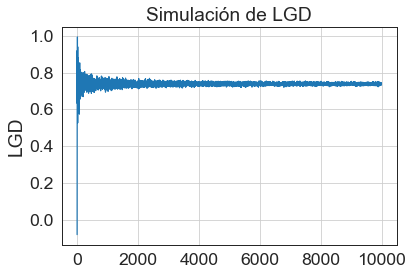

In [131]:
for size in range(1,10000):
    promedio(size)

plt.plot(m1)
plt.ylabel('LGD')
plt.title('Simulación de LGD')
plt.grid(True)

st.t.interval(alpha=0.95, df=len(m1)-1, loc = np.mean(m1), scale=st.sem(m1))